# Valuing resettable convertible bonds:Based on path decomposing

## Data preparation

In [1]:
import pandas_market_calendars as mcal
import pandas as pd
from ic_group import *
from visualize import *
import numpy as np
from datetime import datetime
from scipy.stats import norm

In [2]:
##导入原始数据
data= pd.read_csv('df_call_historic_vol_y.csv')
data= data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
data= data.sort_values(['order_book_id','date'])
data.tail()

,date,order_book_id,open,high,low,close,volume,money,num_trades,value_date,...,historic_vol_20,call_historic_vol_20,historic_vol_60,call_historic_vol_60,historic_vol_250,call_historic_vol_250,time_to_maturity,time_to_protection,non_zero_vol,ccb_option
305417,2023-02-16,128145.XSHE,138.294,138.500,127.000,128.600,2504685.0,3.324278e+08,29119.0,2021-03-22,...,39.556562,128.475551,74.043876,128.475551,68.805307,128.475551,4.095890,0.0001,39.556562,128.475551
305569,2023-02-17,128145.XSHE,128.700,146.000,128.700,132.050,8744586.0,1.196323e+09,100668.0,2021-03-22,...,41.586509,133.173538,74.525707,133.173538,68.977967,133.173538,4.093151,0.0001,41.586509,133.173538
306166,2023-02-20,128145.XSHE,131.768,131.871,125.892,131.670,2545796.0,3.272958e+08,34416.0,2021-03-22,...,40.667225,132.598274,74.521257,132.598274,68.918558,132.598274,4.084932,0.0001,40.667225,132.598274
306644,2023-02-21,128145.XSHE,131.568,133.000,129.200,130.449,907326.0,1.187854e+08,12249.0,2021-03-22,...,40.799740,130.872483,74.423848,130.872483,68.938653,130.872483,4.082192,0.0001,40.799740,130.872483
306987,2023-02-22,128145.XSHE,130.369,130.369,127.001,127.030,584608.0,7.511998e+07,9117.0,2021-03-22,...,41.715308,127.708533,51.265589,127.708533,68.939371,127.708533,4.079452,0.0001,41.715308,127.708533


In [3]:
unique_id=data['order_book_id'].unique().tolist()
print("可转债个数:")
print(len(unique_id))

可转债个数:
743


#### 触发下修条件

In [4]:
##导入下修条件
newdata0=pd.DataFrame()
data_XSHE=pd.DataFrame()
data_XSHE=pd.read_csv("E:/data/option_info/" + unique_id[0] + '.csv',encoding='gbk').drop(columns=['Unnamed: 0'])
data_XSHE=data_XSHE[data_XSHE['option_type']==7].reset_index(drop=True)
data_XSHE['order_book_id']=unique_id[0] 
data_XSHE['start_date']='2014-12-25'
data_XSHE['end_date']='2019-12-25'
newdata0=pd.concat([newdata0,data_XSHE])
newdata0

,option_type,start_date,end_date,payment_year,level,window_days,reach_days,frequency,price,if_include_interest,remark,order_book_id
0,7,2014-12-25,2019-12-25,NaN,0.9,20.0,10.0,随时,NaN,NaN,NaN,110030.XSHG


In [5]:
i=1
while i<=(len(unique_id)-1):
    data_XSHE=pd.read_csv("E:/data/option_info/" + unique_id[i] + '.csv').drop(columns=['Unnamed: 0'])
    data_XSHE=data_XSHE[data_XSHE['option_type']==7].reset_index(drop=True)
    data_XSHE['order_book_id']=unique_id[i] 
    newdata0=pd.concat([newdata0,data_XSHE])
    i=i+1
newdata0.tail()

,option_type,start_date,end_date,payment_year,level,window_days,reach_days,frequency,price,if_include_interest,remark,order_book_id
0,7,2020-12-17,2026-12-17,NaN,0.85,30.0,15.0,随时,NaN,NaN,NaN,128141.XSHE
0,7,2020-12-18,2026-12-18,NaN,0.80,30.0,15.0,随时,NaN,NaN,NaN,128142.XSHE
0,7,2021-01-08,2027-01-08,NaN,0.85,30.0,15.0,随时,NaN,NaN,NaN,128143.XSHE
0,7,2021-03-01,2027-03-01,NaN,0.85,30.0,15.0,随时,NaN,NaN,NaN,128144.XSHE
0,7,2021-03-22,2027-03-22,NaN,0.85,30.0,15.0,随时,NaN,NaN,NaN,128145.XSHE


In [6]:
##加入reset条款的数据
newdata1=pd.merge(data,newdata0,on='order_book_id',how='left')
newdata1.tail()

,date,order_book_id,open,high,low,close,volume,money,num_trades,value_date,...,start_date,end_date,payment_year,level,window_days,reach_days,frequency,price,if_include_interest,remark
350358,2023-02-16,128145.XSHE,138.294,138.500,127.000,128.600,2504685.0,3.324278e+08,29119.0,2021-03-22,...,2021-03-22,2027-03-22,NaN,0.85,30.0,15.0,随时,NaN,NaN,NaN
350359,2023-02-17,128145.XSHE,128.700,146.000,128.700,132.050,8744586.0,1.196323e+09,100668.0,2021-03-22,...,2021-03-22,2027-03-22,NaN,0.85,30.0,15.0,随时,NaN,NaN,NaN
350360,2023-02-20,128145.XSHE,131.768,131.871,125.892,131.670,2545796.0,3.272958e+08,34416.0,2021-03-22,...,2021-03-22,2027-03-22,NaN,0.85,30.0,15.0,随时,NaN,NaN,NaN
350361,2023-02-21,128145.XSHE,131.568,133.000,129.200,130.449,907326.0,1.187854e+08,12249.0,2021-03-22,...,2021-03-22,2027-03-22,NaN,0.85,30.0,15.0,随时,NaN,NaN,NaN
350362,2023-02-22,128145.XSHE,130.369,130.369,127.001,127.030,584608.0,7.511998e+07,9117.0,2021-03-22,...,2021-03-22,2027-03-22,NaN,0.85,30.0,15.0,随时,NaN,NaN,NaN


In [7]:
##判断该天是否触发reset
newdata1['reset_status']=np.where(newdata1['stock_close']<newdata1['conversion_price']*newdata1['level'],1,0)
newdata1['reset_status']

0         1
1         1
2         1
3         1
4         1
         ..
350358    0
350359    0
350360    0
350361    0
350362    0
Name: reset_status, Length: 350363, dtype: int32

In [8]:
newdata1['window_days']=newdata1['window_days'].astype(int)
dict_level = newdata1.set_index('order_book_id')['level'].to_dict()
dict_window_days = newdata1.set_index('order_book_id')['window_days'].to_dict()
dict_reach_days = newdata1.set_index('order_book_id')['reach_days'].to_dict()

In [9]:
def cal(df):   
    code = df['order_book_id'].iloc[0]
    df['fit_days'] = df['reset_status'].rolling(dict_window_days[code]).sum()
    return df

In [10]:
newdata1= newdata1.groupby(['order_book_id']).apply(lambda x:cal(x))
newdata1['status'] = (newdata1['fit_days']>=newdata1['reach_days']).astype(int)
newdata1['is_xx'] = ((newdata1['status']==1)&(newdata1['status'].shift(1)==0)).astype(int)

In [11]:
##全部触发下修条件的可转债
reset_data=pd.DataFrame()
reset_data=newdata1[newdata1['is_xx']==1]
reset_data

,date,order_book_id,open,high,low,close,volume,money,num_trades,value_date,...,window_days,reach_days,frequency,price,if_include_interest,remark,reset_status,fit_days,status,is_xx
19,2019-01-29,110030.XSHG,102.960,102.990,102.910,102.940,17980.0,1.850868e+06,0.0,2014-12-25,...,20,10.0,随时,NaN,NaN,NaN,1,20.0,1,1
248,2019-01-29,110031.XSHG,107.510,108.100,107.100,107.900,193200.0,2.086152e+07,0.0,2015-06-12,...,20,10.0,随时,NaN,NaN,NaN,1,20.0,1,1
537,2020-04-10,110031.XSHG,120.000,120.990,119.050,119.120,12630.0,1.512282e+06,0.0,2015-06-12,...,20,10.0,随时,NaN,NaN,NaN,1,10.0,1,1
891,2019-02-19,110033.XSHG,108.620,109.530,108.060,108.250,11040.0,1.199531e+06,0.0,2016-01-05,...,30,15.0,随时,NaN,NaN,NaN,1,30.0,1,1
953,2019-05-22,110033.XSHG,110.450,110.980,110.000,110.000,9500.0,1.048516e+06,0.0,2016-01-05,...,30,15.0,随时,NaN,NaN,NaN,1,15.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349325,2023-05-12,128143.XSHE,119.684,119.829,117.350,117.640,98040.0,1.158599e+07,2719.0,2021-01-08,...,30,15.0,随时,NaN,NaN,NaN,1,15.0,1,1
349432,2021-07-08,128144.XSHE,106.100,106.700,106.100,106.540,42080.0,4.484038e+06,549.0,2021-03-01,...,30,15.0,随时,NaN,NaN,NaN,1,15.0,1,1
349747,2022-10-27,128144.XSHE,121.096,122.000,119.000,119.000,114967.0,1.384237e+07,1495.0,2021-03-01,...,30,15.0,随时,NaN,NaN,NaN,1,15.0,1,1
349882,2023-05-18,128144.XSHE,114.420,114.998,113.596,114.298,137000.0,1.563069e+07,3310.0,2021-03-01,...,30,15.0,随时,NaN,NaN,NaN,1,15.0,1,1


In [12]:
data=newdata1
# 剩余天数用于 剩余天数和高溢价过滤器
data['r1'] = np.where(data.order_book_id == data.order_book_id.shift(-2),data['close'].shift(-1)/data['open'].shift(-1)-1,0)
data['ro1'] = np.where(data.order_book_id == data.order_book_id.shift(-2),data['open'].shift(-2)/data['open'].shift(-1)-1,0)
data['rc1'] = np.where(data.order_book_id == data.order_book_id.shift(-2),data['close'].shift(-2)/data['close'].shift(-1)-1,0)
data['ro5'] = np.where(data.order_book_id == data.order_book_id.shift(-6),data['open'].shift(-6)/data['open'].shift(-1)-1,0)
data['rc5'] = np.where(data.order_book_id == data.order_book_id.shift(-6),data['close'].shift(-6)/data['close'].shift(-1)-1,0)
data.replace([np.inf, -np.inf], 0, inplace=True)
# 计算超额收益
data = data.set_index('date')
beta_r1 = data.groupby(['date'])['r1'].mean()
beta_r1.name = 'beta_r1'
data['beta_r1'] = beta_r1
data['alpha_r1'] = data['r1'] - data['beta_r1']
beta_ro1 = data.groupby(['date'])['ro1'].mean()
beta_ro1.name = 'beta_ro1'
data['beta_ro1'] = beta_ro1
data['alpha_ro1'] = data['ro1'] - data['beta_ro1']
beta_rc1 = data.groupby(['date'])['rc1'].mean()
beta_rc1.name = 'beta_rc1'
data['beta_rc1'] = beta_rc1
data['alpha_rc1'] = data['rc1'] - data['beta_rc1']
beta_ro5 = data.groupby(['date'])['ro5'].mean()
beta_ro5.name = 'beta_ro5'
data['beta_ro5'] = beta_ro5
data['alpha_ro5'] = data['ro5'] - data['beta_ro5']
beta_rc5 = data.groupby(['date'])['rc5'].mean()
beta_rc5.name = 'beta_rc5'
data['beta_rc5'] = beta_rc5
data['alpha_rc5'] = data['rc5'] - data['beta_rc5']
data = data.reset_index()
data.tail()

,date,order_book_id,open,high,low,close,volume,money,num_trades,value_date,...,beta_r1,alpha_r1,beta_ro1,alpha_ro1,beta_rc1,alpha_rc1,beta_ro5,alpha_ro5,beta_rc5,alpha_rc5
350358,2023-02-16,128145.XSHE,138.294,138.500,127.000,128.600,2504685.0,3.324278e+08,29119.0,2021-03-22,...,-0.009496,0.035525,-0.008667,0.032505,0.009415,-0.012293,-0.000193,0.000193,0.006811,-0.006811
350359,2023-02-17,128145.XSHE,128.700,146.000,128.700,132.050,8744586.0,1.196323e+09,100668.0,2021-03-22,...,0.008592,-0.009335,0.009699,-0.011217,0.002507,-0.011780,0.005507,-0.005507,-0.006384,0.006384
350360,2023-02-20,128145.XSHE,131.768,131.871,125.892,131.670,2545796.0,3.272958e+08,34416.0,2021-03-22,...,0.001430,-0.009935,0.000903,-0.010016,-0.000683,-0.025526,-0.006220,0.006220,-0.006516,0.006516
350361,2023-02-21,128145.XSHE,131.568,133.000,129.200,130.449,907326.0,1.187854e+08,12249.0,2021-03-22,...,-0.000087,0.000087,0.000743,-0.000743,-0.002043,0.002043,-0.005465,0.005465,0.002195,-0.002195
350362,2023-02-22,128145.XSHE,130.369,130.369,127.001,127.030,584608.0,7.511998e+07,9117.0,2021-03-22,...,-0.002848,0.002848,-0.002579,0.002579,-0.002334,0.002334,0.000900,-0.000900,0.003231,-0.003231


<AxesSubplot:>

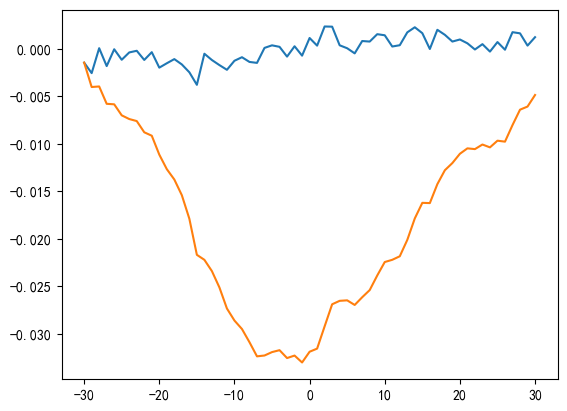

In [13]:
res = {}
res[0] = data[data.is_xx==1]['ro1'].mean()
for i in np.arange(1,31):
    res[i] = data[data.is_xx.shift(i)==1]['ro1'].mean()
for i in np.arange(1,31):
    res[-1*i] = data[data.is_xx.shift(-1*i)==1]['ro1'].mean()
pd.Series(res).sort_index().plot()
pd.Series(res).sort_index().cumsum().plot()

<AxesSubplot:>

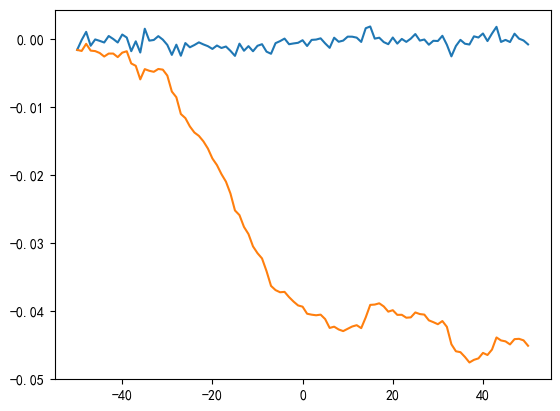

In [14]:
res = {}
res[0] = data[data.is_xx==1]['alpha_ro1'].mean()
for i in np.arange(1,51):
    res[i] = data[data.is_xx.shift(i)==1]['alpha_ro1'].mean()
for i in np.arange(1,51):
    res[-1*i] = data[data.is_xx.shift(-1*i)==1]['alpha_ro1'].mean()
pd.Series(res).sort_index().plot()
pd.Series(res).sort_index().cumsum().plot()

#### 下修公告

In [14]:
import rqdatac
rqdatac.init('18936883872','852963')
print('rqdata 的使用情况如下：')
quota=rqdatac.user.get_quota()
print(quota)

rqdata 的使用情况如下：
{'bytes_used': 9424962, 'bytes_limit': 5368709120.0, 'remaining_days': 146, 'license_type': 'TRIAL'}


In [15]:
unique_id0=reset_data['order_book_id'].unique().tolist()
print("触发下修条件的可转债个数:")
print(len(unique_id0))

触发下修条件的可转债个数:
534


In [16]:
##导入下修公告
df=[pd.DataFrame() for _ in range(len(unique_id0))]
df_stock=[pd.DataFrame() for _ in range(len(unique_id0))]
reset_data_new=pd.DataFrame()
i=0
while i<=(len(unique_id0)-1):
    df[i]=rqdatac.convertible.get_conversion_price(unique_id0[i])#所有修改转股价的数据
    df_stock[i]=df[i][df[i]['change_reason']=='\\股票价格\\']#下修的数据
    reset_data_new=pd.concat([reset_data_new,df_stock[i]])
    i=i+1

In [17]:
##所有发了下修公告的可转债
reset_data_new=reset_data_new.reset_index()
reset_data_new=reset_data_new[reset_data_new['info_date']>'2019-1-1']
reset_data_new=reset_data_new[reset_data_new['info_date']<'2023-2-23']
reset_data_new

,order_book_id,info_date,effective_date,conversion_price,change_reason
0,110030.XSHG,2019-09-28,2019-10-08,5.00,\股票价格\
1,110031.XSHG,2019-12-26,2019-12-27,21.79,\股票价格\
2,110033.XSHG,2019-11-12,2019-11-13,7.42,\股票价格\
3,110038.XSHG,2020-03-03,2020-03-04,25.50,\股票价格\
5,110043.XSHG,2020-04-29,2020-04-30,5.97,\股票价格\
...,...,...,...,...,...
152,128129.XSHE,2021-04-16,2021-04-16,4.47,\股票价格\
153,128133.XSHE,2022-06-11,2022-06-13,24.78,\股票价格\
154,128133.XSHE,2022-10-29,2022-10-31,23.26,\股票价格\
155,128139.XSHE,2022-01-25,2022-01-25,26.38,\股票价格\


In [18]:
unique_id1=reset_data_new['order_book_id'].unique().tolist()
print("有下修公告的可转债个数:")
print(len(unique_id1))

有下修公告的可转债个数:
92


In [19]:
##包含触发下修条件、有下修公告的数据
newdata1['date']=pd.to_datetime(newdata1['date'])
reset_data_new['info_date']=pd.to_datetime(reset_data_new['info_date'])
data=pd.merge(newdata1,reset_data_new, left_on=['order_book_id','date'],right_on=['order_book_id','info_date'],how='left')
data['is_info']=data['info_date'].notnull().astype(int)
data.tail()

,date,order_book_id,open,high,low,close,volume,money,num_trades,value_date,...,r1,ro1,rc1,ro5,rc5,info_date,effective_date,conversion_price_y,change_reason,is_info
350358,2023-02-16,128145.XSHE,138.294,138.500,127.000,128.600,2504685.0,3.324278e+08,29119.0,2021-03-22,...,0.026030,0.023838,-0.002878,0.0,0.0,NaT,NaT,NaN,NaN,0
350359,2023-02-17,128145.XSHE,128.700,146.000,128.700,132.050,8744586.0,1.196323e+09,100668.0,2021-03-22,...,-0.000744,-0.001518,-0.009273,0.0,0.0,NaT,NaT,NaN,NaN,0
350360,2023-02-20,128145.XSHE,131.768,131.871,125.892,131.670,2545796.0,3.272958e+08,34416.0,2021-03-22,...,-0.008505,-0.009113,-0.026209,0.0,0.0,NaT,NaT,NaN,NaN,0
350361,2023-02-21,128145.XSHE,131.568,133.000,129.200,130.449,907326.0,1.187854e+08,12249.0,2021-03-22,...,0.000000,0.000000,0.000000,0.0,0.0,NaT,NaT,NaN,NaN,0
350362,2023-02-22,128145.XSHE,130.369,130.369,127.001,127.030,584608.0,7.511998e+07,9117.0,2021-03-22,...,0.000000,0.000000,0.000000,0.0,0.0,NaT,NaT,NaN,NaN,0


In [48]:
id0=data[data['is_xx']==1]['order_book_id']
reset_data0=data[data['order_book_id'].isin(id0)]
reset_data0

,date,order_book_id,open,high,low,close,volume,money,num_trades,value_date,...,r1,ro1,rc1,ro5,rc5,info_date,effective_date,conversion_price_y,change_reason,is_info
0,2019-01-02,110030.XSHG,102.260,102.350,102.250,102.320,18810.0,1.924131e+06,0.0,2014-12-25,...,-0.000684,-0.000782,0.000684,0.002443,0.003324,NaT,NaT,NaN,NaN,0
1,2019-01-03,110030.XSHG,102.350,102.350,102.200,102.280,40030.0,4.093280e+06,0.0,2014-12-25,...,0.000782,0.000391,0.000293,0.004107,0.002638,NaT,NaT,NaN,NaN,0
2,2019-01-04,110030.XSHG,102.270,102.380,102.240,102.350,30860.0,3.157118e+06,0.0,2014-12-25,...,0.000684,0.000586,-0.000195,0.003519,0.003126,NaT,NaT,NaN,NaN,0
3,2019-01-07,110030.XSHG,102.310,102.440,102.310,102.380,21970.0,2.248901e+06,0.0,2014-12-25,...,-0.000098,-0.000098,0.002052,0.003321,0.003712,NaT,NaT,NaN,NaN,0
4,2019-01-08,110030.XSHG,102.370,102.400,102.350,102.360,9500.0,9.724710e+05,0.0,2014-12-25,...,0.002052,0.002345,0.000487,0.003712,0.002827,NaT,NaT,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350358,2023-02-16,128145.XSHE,138.294,138.500,127.000,128.600,2504685.0,3.324278e+08,29119.0,2021-03-22,...,0.026030,0.023838,-0.002878,0.000000,0.000000,NaT,NaT,NaN,NaN,0
350359,2023-02-17,128145.XSHE,128.700,146.000,128.700,132.050,8744586.0,1.196323e+09,100668.0,2021-03-22,...,-0.000744,-0.001518,-0.009273,0.000000,0.000000,NaT,NaT,NaN,NaN,0
350360,2023-02-20,128145.XSHE,131.768,131.871,125.892,131.670,2545796.0,3.272958e+08,34416.0,2021-03-22,...,-0.008505,-0.009113,-0.026209,0.000000,0.000000,NaT,NaT,NaN,NaN,0
350361,2023-02-21,128145.XSHE,131.568,133.000,129.200,130.449,907326.0,1.187854e+08,12249.0,2021-03-22,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaT,NaT,NaN,NaN,0


In [24]:
reset_data0['yield_to_maturity'].describe()

count    289608.000000
mean         -0.098327
std           1.146350
min         -75.385621
25%          -0.039070
50%          -0.012824
75%           0.007596
max           2.190934
Name: yield_to_maturity, dtype: float64

In [43]:
reset_data0['positive_count']=(reset_data0['yield_to_maturity']>0).groupby(reset_data0['order_book_id']).cumsum()
selected_ids=reset_data0[reset_data0['positive_count']>=10]['order_book_id'].unique()

In [21]:
id=data[data['is_info']==1]['order_book_id']
info_data=data[data['order_book_id'].isin(id)]
info_data

,date,order_book_id,open,high,low,close,volume,money,num_trades,value_date,...,r1,ro1,rc1,ro5,rc5,info_date,effective_date,conversion_price_y,change_reason,is_info
229,2019-01-02,110031.XSHG,105.300,106.510,105.300,105.810,30430.0,3.237914e+06,0.0,2015-06-12,...,0.003490,0.003490,0.001128,0.011978,0.013628,NaT,NaT,NaN,NaN,0
230,2019-01-03,110031.XSHG,106.030,106.640,106.030,106.400,8650.0,9.209410e+05,0.0,2015-06-12,...,0.001128,0.003759,-0.000188,0.013628,0.012017,NaT,NaT,NaN,NaN,0
231,2019-01-04,110031.XSHG,106.400,107.400,106.000,106.520,75790.0,8.085738e+06,0.0,2015-06-12,...,-0.002809,-0.004026,0.004695,0.009738,0.010329,NaT,NaT,NaN,NaN,0
232,2019-01-07,110031.XSHG,106.800,106.800,106.500,106.500,29220.0,3.113613e+06,0.0,2015-06-12,...,0.005923,0.007709,0.002804,0.011563,0.008411,NaT,NaT,NaN,NaN,0
233,2019-01-08,110031.XSHG,106.370,107.000,106.150,107.000,19490.0,2.082980e+06,0.0,2015-06-12,...,0.001026,0.001026,0.005126,0.006624,0.005592,NaT,NaT,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349909,2023-06-28,128144.XSHE,115.178,115.194,114.354,114.497,50500.0,5.791101e+06,1285.0,2021-03-01,...,0.000428,0.000410,0.000445,0.000000,0.000000,NaT,NaT,NaN,NaN,0
349910,2023-06-29,128144.XSHE,114.587,114.998,114.482,114.636,43367.0,4.979503e+06,1063.0,2021-03-01,...,0.000462,0.003018,0.004822,0.000000,0.000000,NaT,NaT,NaN,NaN,0
349911,2023-06-30,128144.XSHE,114.634,115.250,114.609,114.687,98330.0,1.130232e+07,1643.0,2021-03-01,...,0.002261,0.003044,-0.001310,0.000000,0.000000,NaT,NaT,NaN,NaN,0
349912,2023-07-03,128144.XSHE,114.980,115.487,114.840,115.240,67310.0,7.745836e+06,1366.0,2021-03-01,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaT,NaT,NaN,NaN,0


In [25]:
info_data['yield_to_maturity'].describe()

count    51917.000000
mean        -0.063022
std          0.798207
min        -71.734070
25%         -0.034225
50%         -0.006196
75%          0.014347
max          2.190934
Name: yield_to_maturity, dtype: float64

In [32]:
common_elements=set(id)&set(id0)
len(common_elements)/len(id0)

0.0731244064577398

In [65]:
common_elements=set(id)&set(selected_ids)
selected_elements=set(selected_ids)
len(common_elements)/len(selected_elements)

0.17676767676767677

In [66]:
len(common_elements)

70

In [50]:
# Define the China stock exchange calendar
china_calendar = mcal.get_calendar('XSHG')  # 'XSHG' is the code for the Shanghai Stock Exchange

# Define the date range
start_date = pd.Timestamp('2019-01-01')
end_date = pd.Timestamp('2023-07-04')

# Get the trading days between the specified dates
trading_days = china_calendar.schedule(start_date=start_date, end_date=end_date)

# Extract the trading days as a list
trading_days_list = trading_days.index.strftime('%Y-%m-%d').tolist()

In [182]:
lt = []
for date in trading_days_list: 
    lt.append(pd.read_csv("E:/data/stock/cross/" + date + '/shares.csv'))

In [195]:
df_total = pd.concat(lt)
df_total.rename(columns={'order_book_id':'stock_code'},inplace=True)
df_total['date'] = pd.to_datetime(df_total['date'])
df_total.tail()

,date,stock_code,circulation_a,non_circulation_a,total_a,total
5016,2023-07-04,688799.XSHG,5.632070e+07,37479300.0,9.380000e+07,9.380000e+07
5017,2023-07-04,688800.XSHG,1.046991e+08,53720800.0,1.584199e+08,1.584199e+08
5018,2023-07-04,688819.XSHG,1.309000e+08,841200000.0,9.721000e+08,9.721000e+08
5019,2023-07-04,688981.XSHG,1.957403e+09,0.0,1.957403e+09,7.925937e+09
5020,2023-07-04,689009.XSHG,5.117004e+07,20474815.0,7.164486e+07,7.164486e+07


In [198]:
reset_data0 = pd.merge(reset_data0,df_total,on=['date','stock_code'],how='left')
reset_data0.tail()

,date,order_book_id,open,high,low,close,volume,money,num_trades,value_date,...,effective_date,conversion_price_y,change_reason,is_info,stock_total,remaining_ratio,circulation_a,non_circulation_a,total_a,total
289808,2023-02-16,128145.XSHE,138.294,138.500,127.000,128.600,2504685.0,3.324278e+08,29119.0,2021-03-22,...,NaT,NaN,NaN,0,329122732.0,0.585923,173435824.0,155686908.0,329122732.0,329122732.0
289809,2023-02-17,128145.XSHE,128.700,146.000,128.700,132.050,8744586.0,1.196323e+09,100668.0,2021-03-22,...,NaT,NaN,NaN,0,329122732.0,0.584309,173435824.0,155686908.0,329122732.0,329122732.0
289810,2023-02-20,128145.XSHE,131.768,131.871,125.892,131.670,2545796.0,3.272958e+08,34416.0,2021-03-22,...,NaT,NaN,NaN,0,329122732.0,0.465766,173435824.0,155686908.0,329122732.0,329122732.0
289811,2023-02-21,128145.XSHE,131.568,133.000,129.200,130.449,907326.0,1.187854e+08,12249.0,2021-03-22,...,NaT,NaN,NaN,0,329122732.0,0.465766,173435824.0,155686908.0,329122732.0,329122732.0
289812,2023-02-22,128145.XSHE,130.369,130.369,127.001,127.030,584608.0,7.511998e+07,9117.0,2021-03-22,...,NaT,NaN,NaN,0,341193842.0,0.322140,185506934.0,155686908.0,341193842.0,341193842.0


In [201]:
info_data['date']=pd.to_datetime(info_data['date'])

In [202]:
info_data = pd.merge(info_data,df_total,on=['date','stock_code'],how='left')
info_data.tail()

,Unnamed: 0,date,order_book_id,open,high,low,close,volume,money,num_trades,...,beta_ro5,alpha_ro5,beta_rc5,alpha_rc5,stock_total,remaining_ratio,circulation_a,non_circulation_a,total_a,total
51927,349909,2023-06-28,128144.XSHE,115.178,115.194,114.354,114.497,50500.0,5.791101e+06,1285.0,...,0.0,0.0,0.0,0.0,371216022,2.638302,325077805.0,46138217.0,371216022.0,371216022.0
51928,349910,2023-06-29,128144.XSHE,114.587,114.998,114.482,114.636,43367.0,4.979503e+06,1063.0,...,0.0,0.0,0.0,0.0,371216022,2.638299,325077805.0,46138217.0,371216022.0,371216022.0
51929,349911,2023-06-30,128144.XSHE,114.634,115.250,114.609,114.687,98330.0,1.130232e+07,1643.0,...,0.0,0.0,0.0,0.0,371216022,2.638299,325077805.0,46138217.0,371216022.0,371216022.0
51930,349912,2023-07-03,128144.XSHE,114.980,115.487,114.840,115.240,67310.0,7.745836e+06,1366.0,...,0.0,0.0,0.0,0.0,371216022,2.638299,325077805.0,46138217.0,371216022.0,371216022.0
51931,349913,2023-07-04,128144.XSHE,115.330,115.444,115.039,115.089,36590.0,4.218774e+06,625.0,...,0.0,0.0,0.0,0.0,371216113,2.638298,325077896.0,46138217.0,371216113.0,371216113.0


In [204]:
info_data['remaining_ratio1']=info_data['remaining_size']/info_data['circulation_a']
info_data['remaining_ratio1'].describe()

count    51917.000000
mean         1.877779
std          2.084602
min          0.012026
25%          0.712517
50%          1.300415
75%          2.117324
max         16.266750
Name: remaining_ratio1, dtype: float64

In [206]:
info_data['remaining_ratio2']=info_data['remaining_size']/info_data['total_a']
info_data['remaining_ratio2'].describe()

count    51917.000000
mean         1.293949
std          0.913926
min          0.010391
25%          0.665932
50%          1.069266
75%          1.674958
max          5.759847
Name: remaining_ratio2, dtype: float64

In [205]:
reset_data0['remaining_ratio1']=reset_data0['remaining_size']/reset_data0['circulation_a']
reset_data0['remaining_ratio1'].describe()

count    289608.000000
mean          2.073255
std           2.580162
min           0.006363
25%           0.777146
50%           1.315694
75%           2.291872
max          37.415398
Name: remaining_ratio1, dtype: float64

In [207]:
reset_data0['remaining_ratio2']=reset_data0['remaining_size']/reset_data0['total_a']
reset_data0['remaining_ratio2'].describe()

count    289608.000000
mean          1.397334
std           1.211166
min           0.005144
25%           0.678615
50%           1.097022
75%           1.732356
max          19.780193
Name: remaining_ratio2, dtype: float64

In [407]:
filtered_data=reset_data0.groupby('order_book_id').filter(lambda x:(x['remaining_ratio1'].max()<5)&(x['remaining_ratio2'].max()<5))
selected_ids1=filtered_data['order_book_id'].unique()

In [408]:
common_elements=set(id)&set(selected_ids)&set(selected_ids1)
selected_elements=set(selected_ids)&set(selected_ids1)
len(common_elements)/len(selected_elements)

0.18731117824773413

In [409]:
len(common_elements)

62

In [104]:
info_data['yield_to_maturity'].describe()

count    51917.000000
mean        -0.063022
std          0.798207
min        -71.734070
25%         -0.034225
50%         -0.006196
75%          0.014347
max          2.190934
Name: yield_to_maturity, dtype: float64

In [95]:
info_data.to_csv('info_data.csv') 

In [45]:
info_data=pd.read_csv('info_data.csv')
info_data.tail()

,Unnamed: 0,date,order_book_id,open,high,low,close,volume,money,num_trades,...,beta_ro1,alpha_ro1,beta_rc1,alpha_rc1,beta_ro5,alpha_ro5,beta_rc5,alpha_rc5,stock_total,remaining_ratio
51927,349909,2023-06-28,128144.XSHE,115.178,115.194,114.354,114.497,50500.0,5.791101e+06,1285.0,...,0.004619,-0.004209,0.003931,-0.003486,0.0,0.0,0.0,0.0,371216022,2.638302
51928,349910,2023-06-29,128144.XSHE,114.587,114.998,114.482,114.636,43367.0,4.979503e+06,1063.0,...,0.004296,-0.001278,0.003554,0.001268,0.0,0.0,0.0,0.0,371216022,2.638299
51929,349911,2023-06-30,128144.XSHE,114.634,115.250,114.609,114.687,98330.0,1.130232e+07,1643.0,...,0.003293,-0.000249,0.002500,-0.003810,0.0,0.0,0.0,0.0,371216022,2.638299
51930,349912,2023-07-03,128144.XSHE,114.980,115.487,114.840,115.240,67310.0,7.745836e+06,1366.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,371216022,2.638299
51931,349913,2023-07-04,128144.XSHE,115.330,115.444,115.039,115.089,36590.0,4.218774e+06,625.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,371216113,2.638298


In [102]:
##下修当天
info_data_new=info_data[info_data['is_info']==1]
info_data_new['info_date']=pd.to_datetime(info_data_new['info_date'])
info_data_new['end_date']=pd.to_datetime(info_data_new['end_date'])
info_data_new['conversion_end_date']=pd.to_datetime(info_data_new['conversion_end_date'])
info_data_new['expire']=info_data_new['conversion_end_date']-info_data_new['info_date']#无明显效果
info_data_new['yield_to_maturity'].describe()
#info_data_new.tail
#info_data_new[['end_date','conversion_end_date']]

count    88.000000
mean     -0.018195
std       0.073612
min      -0.443032
25%      -0.025928
50%      -0.004908
75%       0.015875
max       0.043062
Name: yield_to_maturity, dtype: float64

In [103]:
info_data_new['remaining_ratio'].describe()

count    88.000000
mean      1.566283
std       1.092960
min       0.080022
25%       0.783595
50%       1.338159
75%       1.970557
max       5.756810
Name: remaining_ratio, dtype: float64

In [97]:
##下修前20天数据
is_info_rows=info_data[info_data['is_info']==1].index
result_rows=[]
for index in is_info_rows:
    start_index=max(0,index-20)
    result_rows.extend(info_data.loc[start_index:index+1].to_dict('records'))
result_info=pd.DataFrame(result_rows)
result_info['remaining_ratio'].describe()

count    1931.000000
mean        1.565876
std         1.089195
min         0.040206
25%         0.786737
50%         1.337958
75%         1.999387
max         5.756852
Name: remaining_ratio, dtype: float64

In [105]:
result_info['yield_to_maturity'].describe()

count    1931.000000
mean       -0.068016
std         1.175549
min       -34.528554
25%        -0.018395
50%         0.001111
75%         0.020856
max         0.091956
Name: yield_to_maturity, dtype: float64

In [25]:
id=result_info['order_book_id'].unique().tolist()
group_data=result_info.groupby('order_book_id')
i=0
grouped_data=[pd.DataFrame() for _ in range(len(id))]
while i<=(len(id)-1):
    grouped_data[i]=group_data.get_group(id[i])
    i=i+1

In [99]:
##下修前40-21天数据
result_rows=[]
for index in is_info_rows:
    start_index=max(0,index-20)
    result_rows.extend(info_data.loc[start_index-20:index-19].to_dict('records'))
result_notinfo=pd.DataFrame(result_rows)
result_notinfo['remaining_ratio'].describe()

count    1862.000000
mean        1.555451
std         1.083772
min         0.080022
25%         0.774170
50%         1.337991
75%         1.999555
max         5.756868
Name: remaining_ratio, dtype: float64

In [106]:
result_notinfo['yield_to_maturity'].describe()

count    1862.000000
mean       -0.145301
std         1.428089
min       -29.838374
25%        -0.013124
50%         0.006510
75%         0.025805
max         0.091956
Name: yield_to_maturity, dtype: float64

In [27]:
id=result_notinfo['order_book_id'].unique().tolist()
group_data=result_notinfo.groupby('order_book_id')
i=0
grouped_data=[pd.DataFrame() for _ in range(len(id))]
while i<=(len(id)-1):
    grouped_data[i]=group_data.get_group(id[i])
    i=i+1

In [28]:
np.mean([ x.close.max() for x in grouped_data ])

117.19086842105264

In [29]:
data['r1'] = np.where(data.order_book_id == data.order_book_id.shift(-2),data['close'].shift(-1)/data['open'].shift(-1)-1,0)
data['ro1'] = np.where(data.order_book_id == data.order_book_id.shift(-2),data['open'].shift(-2)/data['open'].shift(-1)-1,0)
data['rc1'] = np.where(data.order_book_id == data.order_book_id.shift(-2),data['close'].shift(-2)/data['close'].shift(-1)-1,0)
data['ro5'] = np.where(data.order_book_id == data.order_book_id.shift(-6),data['open'].shift(-6)/data['open'].shift(-1)-1,0)
data['rc5'] = np.where(data.order_book_id == data.order_book_id.shift(-6),data['close'].shift(-6)/data['close'].shift(-1)-1,0)
data.replace([np.inf, -np.inf], 0, inplace=True)
# 计算超额收益
data = data.set_index('date')
beta_r1 = data.groupby(['date'])['r1'].mean()
beta_r1.name = 'beta_r1'
data['beta_r1'] = beta_r1
data['alpha_r1'] = data['r1'] - data['beta_r1']
beta_ro1 = data.groupby(['date'])['ro1'].mean()
beta_ro1.name = 'beta_ro1'
data['beta_ro1'] = beta_ro1
data['alpha_ro1'] = data['ro1'] - data['beta_ro1']
beta_rc1 = data.groupby(['date'])['rc1'].mean()
beta_rc1.name = 'beta_rc1'
data['beta_rc1'] = beta_rc1
data['alpha_rc1'] = data['rc1'] - data['beta_rc1']
beta_ro5 = data.groupby(['date'])['ro5'].mean()
beta_ro5.name = 'beta_ro5'
data['beta_ro5'] = beta_ro5
data['alpha_ro5'] = data['ro5'] - data['beta_ro5']
beta_rc5 = data.groupby(['date'])['rc5'].mean()
beta_rc5.name = 'beta_rc5'
data['beta_rc5'] = beta_rc5
data['alpha_rc5'] = data['rc5'] - data['beta_rc5']
data = data.reset_index()
data.tail()

,date,order_book_id,open,high,low,close,volume,money,num_trades,value_date,...,beta_r1,alpha_r1,beta_ro1,alpha_ro1,beta_rc1,alpha_rc1,beta_ro5,alpha_ro5,beta_rc5,alpha_rc5
350358,2023-02-16,128145.XSHE,138.294,138.500,127.000,128.600,2504685.0,3.324278e+08,29119.0,2021-03-22,...,-0.009496,0.035525,-0.008667,0.032505,0.009415,-0.012293,-0.000193,0.000193,0.006811,-0.006811
350359,2023-02-17,128145.XSHE,128.700,146.000,128.700,132.050,8744586.0,1.196323e+09,100668.0,2021-03-22,...,0.008592,-0.009335,0.009699,-0.011217,0.002507,-0.011780,0.005507,-0.005507,-0.006384,0.006384
350360,2023-02-20,128145.XSHE,131.768,131.871,125.892,131.670,2545796.0,3.272958e+08,34416.0,2021-03-22,...,0.001430,-0.009935,0.000903,-0.010016,-0.000683,-0.025526,-0.006220,0.006220,-0.006516,0.006516
350361,2023-02-21,128145.XSHE,131.568,133.000,129.200,130.449,907326.0,1.187854e+08,12249.0,2021-03-22,...,-0.000087,0.000087,0.000743,-0.000743,-0.002043,0.002043,-0.005465,0.005465,0.002195,-0.002195
350362,2023-02-22,128145.XSHE,130.369,130.369,127.001,127.030,584608.0,7.511998e+07,9117.0,2021-03-22,...,-0.002848,0.002848,-0.002579,0.002579,-0.002334,0.002334,0.000900,-0.000900,0.003231,-0.003231


<AxesSubplot:>

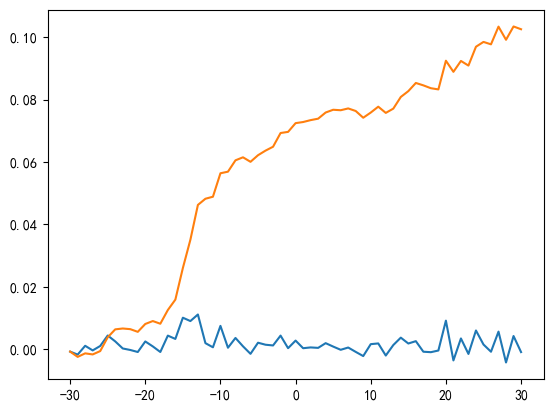

In [30]:
res = {}
res[0] = data[data.is_info==1]['ro1'].mean()
for i in np.arange(1,31):
    res[i] = data[data.is_info.shift(i)==1]['ro1'].mean()
for i in np.arange(1,31):
    res[-1*i] = data[data.is_info.shift(-1*i)==1]['ro1'].mean()
pd.Series(res).sort_index().plot()
pd.Series(res).sort_index().cumsum().plot()

<AxesSubplot:>

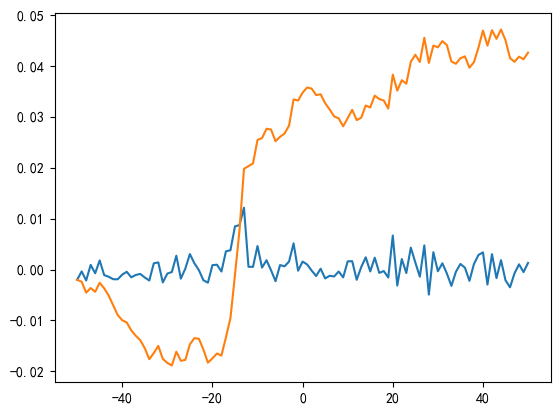

In [31]:
res = {}
res[0] = data[data.is_info==1]['alpha_ro1'].mean()
for i in np.arange(1,51):
    res[i] = data[data.is_info.shift(i)==1]['alpha_ro1'].mean()
for i in np.arange(1,51):
    res[-1*i] = data[data.is_info.shift(-1*i)==1]['alpha_ro1'].mean()
pd.Series(res).sort_index().plot()
pd.Series(res).sort_index().cumsum().plot()

#### 数据汇总

In [32]:
##统计符合条件的可转债个数(此处同一可转债可计入多次)
print("可转债总个数:")
print(len(unique_id))
print("触发下修条件的次数:")#reset_data
print(len(reset_data))
print("有下修公告的次数:")#reset_data_new
print(len(reset_data_new))

可转债总个数:
743
触发下修条件的次数:
1053
有下修公告的次数:
108


In [34]:
print("在触发下修的可转债中,有下修公告的比例：")
print(round(len(reset_data_new)/len(reset_data),2))

在触发下修的可转债中,有下修公告的比例：
0.1


In [121]:
##包含触发下修条件、发下修公告的总表
data.tail()

,date,order_book_id,open,high,low,close,volume,money,num_trades,value_date,...,beta_ro1,alpha_ro1,beta_rc1,alpha_rc1,beta_ro5,alpha_ro5,beta_rc5,alpha_rc5,ccdb,rcb
350358,2023-02-16,128145.XSHE,138.294,138.500,127.000,128.600,2504685.0,3.324278e+08,29119.0,2021-03-22,...,-0.008667,0.032505,0.009415,-0.012293,-0.000193,0.000193,0.006811,-0.006811,211.179637,211.179637
350359,2023-02-17,128145.XSHE,128.700,146.000,128.700,132.050,8744586.0,1.196323e+09,100668.0,2021-03-22,...,0.009699,-0.011217,0.002507,-0.011780,0.005507,-0.005507,-0.006384,0.006384,215.534576,215.534576
350360,2023-02-20,128145.XSHE,131.768,131.871,125.892,131.670,2545796.0,3.272958e+08,34416.0,2021-03-22,...,0.000903,-0.010016,-0.000683,-0.025526,-0.006220,0.006220,-0.006516,0.006516,215.015264,215.015264
350361,2023-02-21,128145.XSHE,131.568,133.000,129.200,130.449,907326.0,1.187854e+08,12249.0,2021-03-22,...,0.000743,-0.000743,-0.002043,0.002043,-0.005465,0.005465,0.002195,-0.002195,213.421661,213.421661
350362,2023-02-22,128145.XSHE,130.369,130.369,127.001,127.030,584608.0,7.511998e+07,9117.0,2021-03-22,...,-0.002579,0.002579,-0.002334,0.002334,0.000900,-0.000900,0.003231,-0.003231,210.496365,210.496365


In [36]:
reset_data['date']=pd.to_datetime(reset_data['date'])
reset_data['date']

19       2019-01-29
248      2019-01-29
537      2020-04-10
891      2019-02-19
953      2019-05-22
            ...    
349325   2023-05-12
349432   2021-07-08
349747   2022-10-27
349882   2023-05-18
349943   2021-06-01
Name: date, Length: 1053, dtype: datetime64[ns]

In [37]:
data_interval=pd.merge(reset_data_new,reset_data,on=['order_book_id'],how='left')
data_interval=data_interval[data_interval['date']<data_interval['info_date']]
data_interval['interval']=data_interval['info_date']-data_interval['date']
result_index=data_interval.groupby(['order_book_id','info_date'])['date'].idxmax()
result=data_interval.loc[result_index]
result.rename(columns={'date':'trigger_date'},inplace=True)
result_index=result.groupby(['order_book_id','trigger_date'])['info_date'].idxmin()
result=result.loc[result_index]
result

,order_book_id,info_date,effective_date,conversion_price_x,change_reason,trigger_date,open,high,low,close,...,reach_days,frequency,price,if_include_interest,remark,reset_status,fit_days,status,is_xx,interval
0,110030.XSHG,2019-09-28,2019-10-08,5.00,\股票价格\,2019-01-29,102.960,102.990,102.910,102.940,...,10.0,随时,NaN,NaN,NaN,1,20.0,1,1,242 days
1,110031.XSHG,2019-12-26,2019-12-27,21.79,\股票价格\,2019-01-29,107.510,108.100,107.100,107.900,...,10.0,随时,NaN,NaN,NaN,1,20.0,1,1,331 days
4,110033.XSHG,2019-11-12,2019-11-13,7.42,\股票价格\,2019-05-22,110.450,110.980,110.000,110.000,...,15.0,随时,NaN,NaN,NaN,1,15.0,1,1,174 days
7,110038.XSHG,2020-03-03,2020-03-04,25.50,\股票价格\,2019-02-19,114.610,115.130,112.180,113.180,...,10.0,随时,NaN,NaN,NaN,1,26.0,1,1,378 days
12,110043.XSHG,2020-04-29,2020-04-30,5.97,\股票价格\,2019-08-16,104.070,104.500,104.020,104.490,...,15.0,随时,NaN,NaN,NaN,1,15.0,1,1,257 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,128129.XSHE,2021-04-16,2021-04-16,4.47,\股票价格\,2021-02-09,100.559,102.103,100.302,101.650,...,15.0,随时,NaN,NaN,NaN,1,15.0,1,1,66 days
255,128133.XSHE,2022-06-11,2022-06-13,24.78,\股票价格\,2022-04-26,109.728,111.030,108.521,109.006,...,10.0,随时,NaN,NaN,NaN,1,10.0,1,1,46 days
262,128133.XSHE,2022-10-29,2022-10-31,23.26,\股票价格\,2022-10-12,113.980,116.843,113.790,116.700,...,10.0,随时,NaN,NaN,NaN,1,10.0,1,1,17 days
264,128139.XSHE,2022-01-25,2022-01-25,26.38,\股票价格\,2021-05-28,97.403,97.600,97.300,97.307,...,15.0,随时,NaN,NaN,NaN,1,15.0,1,1,242 days


In [444]:
result['close'].describe()

count     94.000000
mean     110.963468
std       25.440633
min       86.310000
25%       99.037500
50%      107.086500
75%      115.256750
max      294.000000
Name: close, dtype: float64

In [416]:
reset_data1=result[result['call_historic_vol_10']>80]
reset_data1['interval'].median()#21
result=result.drop(reset_data1.index)
reset_data2=result[result['stock_high']-result['stock_low']>1.2]
result=result.drop(reset_data2.index)
reset_data3=result[result['historic_vol_10']<3]#174
result=result.drop(reset_data3.index)
reset_data4=result[result['logreturn_y']<-2]
result=result.drop(reset_data4.index)
result['interval'].median()#len(result)=37
reset_data5=result[result['conversion_price_x']>20]
reset_data5['interval'].median()
result=result.drop(reset_data5.index)
reset_data6=result[result['open']<110]
reset_data6['interval']#.median()
result0=pd.concat([reset_data1,reset_data5,reset_data6])
result0['interval'].median()#50

Timedelta('21 days 00:00:00')

In [421]:
result1=result[result['interval']<='50 days']
x=result1.median()
x
result2=result[result['interval']>'50 days']
y=result2.median()
y

conversion_price_x                7.96
open                           104.695
high                          106.2685
low                             104.35
close                         104.9505
                            ...       
reset_status                       1.0
fit_days                          15.0
status                             1.0
is_xx                              1.0
interval              23 days 00:00:00
Length: 89, dtype: object

## RCB Model

In [107]:
def ccdb(S0,BF,P1,P2,T,r,vol):
    """
    reference:Analytic valuation of the callable convertible discount bonds:Equivalent decomposition method 
    input:
    BF  面值(par_value)
    S0  在当前时刻标的股价(stock_close)
    P1  转股价(coversion_price)
    P2  赎回(default 130)
    T   剩余期限(time_to_maturity)
    r   无风险log return(default np.log(1.02))
    vol 波动率
    """
    return (BF/P1)*ABC_i1(S0,T,P1,P2,r,vol)+(BF/P1)*UOC(S0,T,P1,P2,r,vol)+ABC_i2(S0,T,BF,P2,r,vol)-ABC_d(BF,S0,T,P2,r,vol)+DB(BF,T,r)

# 由于计算过程冗杂，出现复杂表达式，以下表达式主要用于简化
# u=(r-vol**2/2)/vol
# u_hat=(r+vol**2/2)/(vol**2)
# x=(np.log(S0/P2))/(vol*np.sqrt(T))+u_hat*vol*np.sqrt(T)
# d1=(np.log(S0/P1)+(r+vol**2/2)*T)/(vol*np.sqrt(T))
# z=(np.log(P2/S0))/(vol*np.sqrt(T))+u_hat*vol*np.sqrt(T)
# z1=(np.log(P2**2/(P1*S0)))/(vol*np.sqrt(T))+u_hat*vol*np.sqrt(T)
# u_tu=np.sqrt(u**2+2*r)
# y=np.log(P2/S0)/vol
# a1=(y+u_tu*T)/np.sqrt(T)
# a2=(y-u_tu*T)/np.sqrt(T)
# a3=(y+u*T)/np.sqrt(T)
# a4=(y-u*T)/np.sqrt(T)

def ABC_i1(S0,T,P1,P2,r,vol): # 投资者拥有的障碍水平为P2，固定支付额为(P2-P1)的立即支付型规则美式二期买权
    u=(r-vol**2/2)/vol
    u_tu=np.sqrt(u**2+2*r)
    y=np.log(P2/S0)/vol
    a1=(y+u_tu*T)/np.sqrt(T)
    a2=(y-u_tu*T)/np.sqrt(T)
    return (P2-P1)*np.exp(y*(u-u_tu))*(norm.cdf(-a2)+np.exp(2*y*u_tu)*norm.cdf(-a1))

def UOC(S0,T,P1,P2,r,vol): # 投资者拥有的执行价格为P1，障碍水平为P2的规则向上敲出买权
    u_hat=(r+vol**2/2)/(vol**2)
    d1=(np.log(S0/P1)+(r+vol**2/2)*T)/(vol*np.sqrt(T))
    x=(np.log(S0/P2))/(vol*np.sqrt(T))+u_hat*vol*np.sqrt(T)
    z=(np.log(P2/S0))/(vol*np.sqrt(T))+u_hat*vol*np.sqrt(T)
    z1=(np.log(P2**2/(P1*S0)))/(vol*np.sqrt(T))+u_hat*vol*np.sqrt(T)
    return S0*(norm.cdf(d1)-norm.cdf(x))+P1*np.exp(-r*T)*(norm.cdf(x-vol*np.sqrt(T))-norm.cdf(d1-vol*np.sqrt(T)))\
        +S0*((P2/S0)**(2*u_hat))*(norm.cdf(-z)-norm.cdf(-z1))\
        +P1*np.exp(-r*T)*((P2/S0)**(2*u_hat-2))*(norm.cdf(-z1+vol*np.sqrt(T))-norm.cdf(-z+vol*np.sqrt(T)))

def ABC_i2(S0,T,BF,P2,r,vol): # 投资者拥有的障碍水平为P2，固定支付额为BF的立即支付型规则美式二期买权
    u=(r-vol**2/2)/vol
    u_tu=np.sqrt(u**2+2*r)
    y=np.log(P2/S0)/vol
    a1=(y+u_tu*T)/np.sqrt(T)
    a2=(y-u_tu*T)/np.sqrt(T)
    return BF*np.exp(y*(u-u_tu))*(norm.cdf(-a2)+np.exp(2*y*u_tu)*norm.cdf(-a1))

def ABC_d(BF,S0,T,P2,r,vol): #发行者拥有的障碍水平为P2，固定支付额为BF的延迟支付型规则美式二期买权
    u=(r-vol**2/2)/vol
    y=np.log(P2/S0)/vol
    a3=(y+u*T)/np.sqrt(T)
    a4=(y-u*T)/np.sqrt(T)
    return BF*np.exp(-r*T)*(norm.cdf(-a4)+(P2/S0)**((2*r-vol**2)/(vol**2))*norm.cdf(-a3))

def DB(BF,T,r): #贴现债券
    return BF*np.exp(-r*T)

In [110]:
data['conversion_price_x']

0          6.94
1          6.94
2          6.94
3          6.94
4          6.94
          ...  
350358    10.43
350359    10.43
350360    10.43
350361    10.43
350362    10.43
Name: conversion_price_x, Length: 350363, dtype: float64

In [111]:
data['ccdb'] = data.apply(lambda row: ccdb(row['stock_close'],row['par_value'],row['conversion_price_x'],130,row['time_to_maturity'],np.log(1.02),row['non_zero_vol']), axis=1)

In [112]:
data['rcb'] = data.apply(lambda row: ccdb(row['stock_close'],row['par_value'],0.7*row['conversion_price_x'],0.7*130,row['time_to_maturity'],np.log(1.02),row['non_zero_vol']), axis=1)

In [113]:
data['rcb']=np.where(data['is_info']==0,data['ccdb'],data['rcb'])

In [ ]:
data['rcb']

In [114]:
def plot_comparison(df_i,order_book_id,mode):
    """
    Show the plot of close price and theoretically predicted price.
    The volitility is also shown in the plot.
    ------
    Parameter:
    df_i(dataframe): the dataframe with the price of one mode.
    order_book_id(str)
    mode(str): chosen from 'BSM_rq_iv', 'BSM_nt_iv', 'BSM_his_vol'
    ------
    Output:
    Line plot
    """
    if mode == 'BSM_rq_iv':
        call_name='call_rq_iv'
        vol_name='IMPLIEDVOL'
    elif mode == 'BSM_nt_iv':
        call_name='call_nt_iv'
        vol_name='IV_ConvBond'
    elif mode == 'rcb':
        call_name='rcb'
        vol_name='non_zero_vol'
    else: # BSM_his_vol
        winlen = mode.split("_")[-1]
        call_name=f'call_historic_vol_{winlen}'
        vol_name=f'historic_vol_{winlen}'

    x = df_i['date']
    y1 = (df_i[call_name]).shift(-1)
    y2 = df_i[vol_name]
    y3 = df_i['close']
    fig, ax1 = plt.subplots()

    # Plot the first dataset
    ax1.plot(x, y1, 'b-', label='rcb')
    ax1.plot(x, y3, 'r', label='close')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='b')
    ax1.tick_params('y', colors='b')

    # Create the second subplot
    ax2 = ax1.twinx()

    # Plot the second dataset
    ax2.plot(x, y2, 'g', label='vol')
    ax2.set_ylabel('VOL', color='r')
    ax2.tick_params('y', colors='r')

    # Add a legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    plt.title(order_book_id)
    # Display the plot
    plt.show()

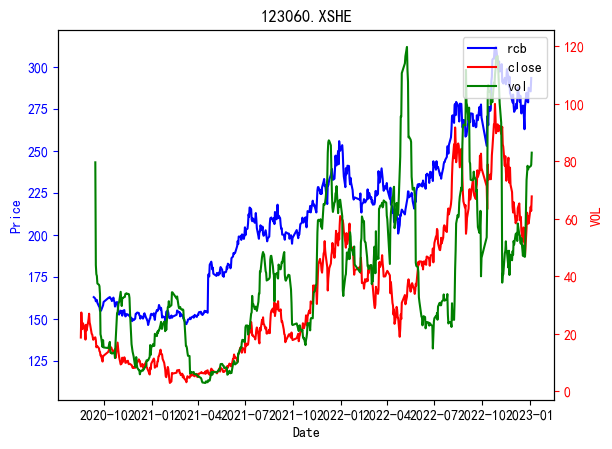

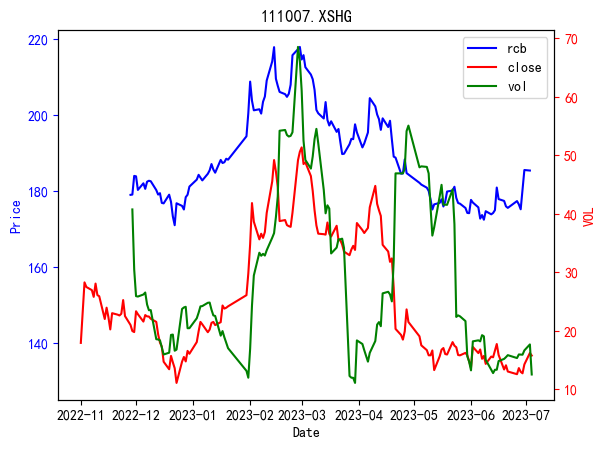

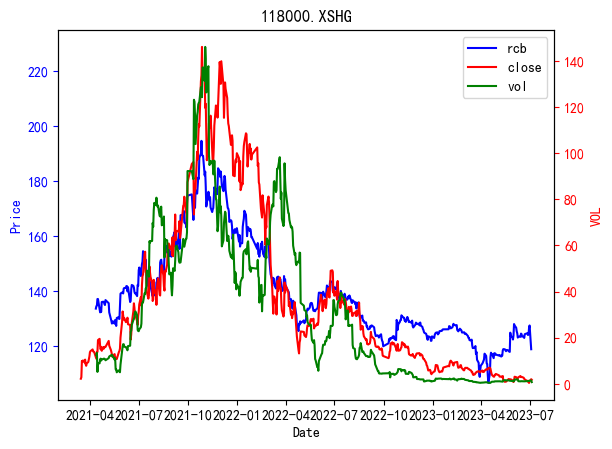

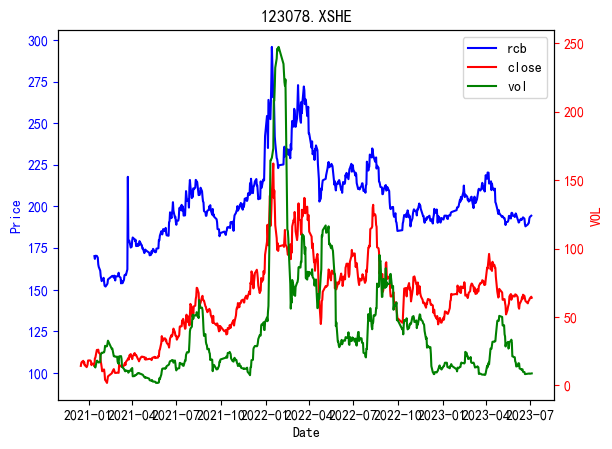

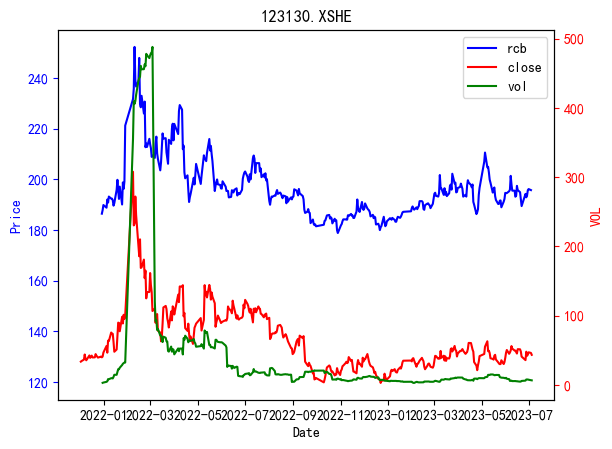

In [115]:
order_book_id_lis = list(set(data['order_book_id']))
# plot of some examples
for i in range(0,5):
    order_book_id = order_book_id_lis[i]
    df_i = data[data['order_book_id']==order_book_id]
    #mpl.rcParams['font.family'] = 'Times New Roman'
    plot_comparison(df_i,order_book_id,'rcb')

In [116]:
from visualize import *
from ic_group import *
#mpl.rcParams['font.family'] = 'Times New Roman'
df = data
df = df.sort_values(['order_book_id','date'])
# 构建因子 
# df['factor1'] = np.where(df.order_book_id == df.order_book_id.shift(20),df.close/df.close.shift(20)-1,np.nan)
df['price_diff'] = df['close'] - df['rcb']
df['factor1']=df['rcb']/df['close']-1
df['new_price']=df['rcb']*(df['close'].shift(1)/df['rcb'].shift(2)\
                            +df['close'].shift(3)/df['rcb'].shift(4)\
                            +df['close'].shift(5)/df['rcb'].shift(6)\
                            +df['close'].shift(6)/df['rcb'].shift(8)\
                            +df['close'].shift(8)/df['rcb'].shift(10))/5
df['factor2']=np.where(df.order_book_id==df.order_book_id.shift(10),df['new_price']/df['close']-1,0)
factor ='price_diff'
factor1='factor1'
factor2='factor2'
# 预测收益
df['r'] = np.where(df.order_book_id == df.order_book_id.shift(-2),df.open.shift(-2)/df.open.shift(-1)-1,0)
r= 'r'
#data0 = df
data0 = df[['date','order_book_id','r','factor1','factor2',factor]].dropna()
data0 = data0[~np.isinf(data0['r'])]
data0 = data0[data0['date']>'2021-05-01']
data0['date'] = data0['date'].apply(lambda x:str(x)[:10])

<Figure size 1500x1200 with 0 Axes>

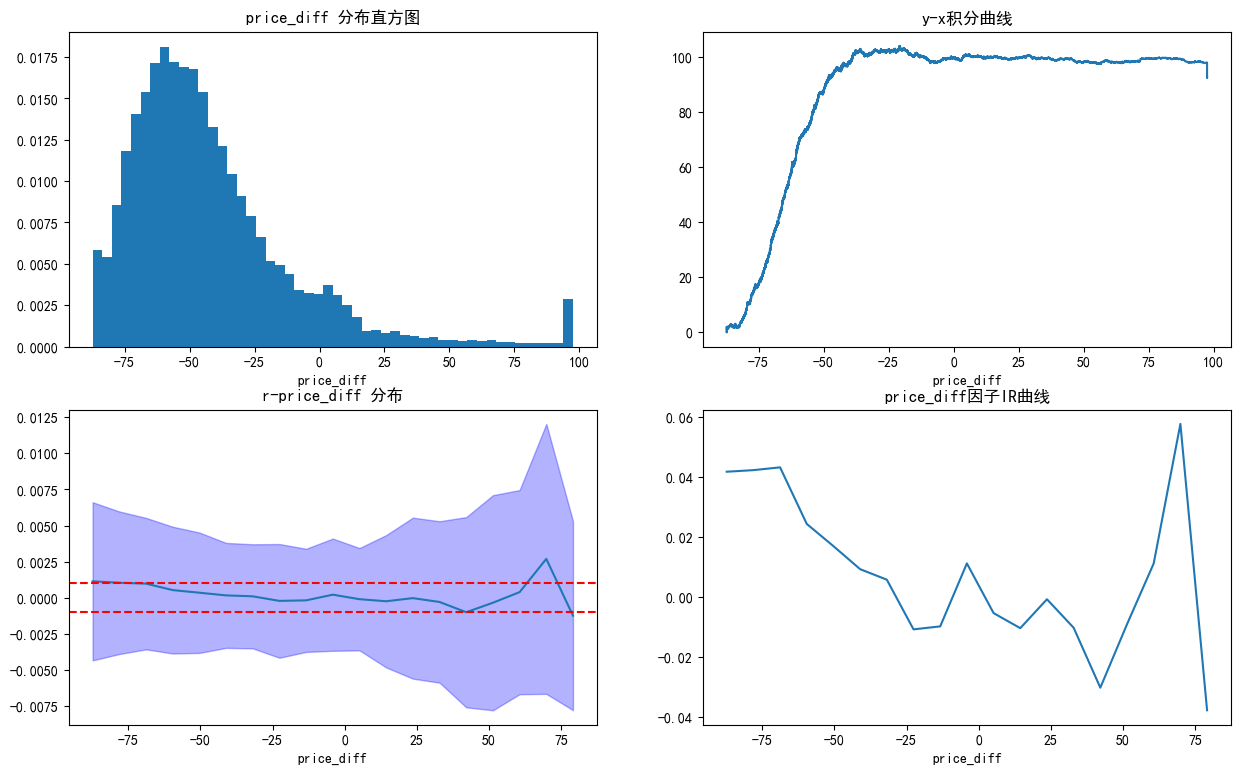

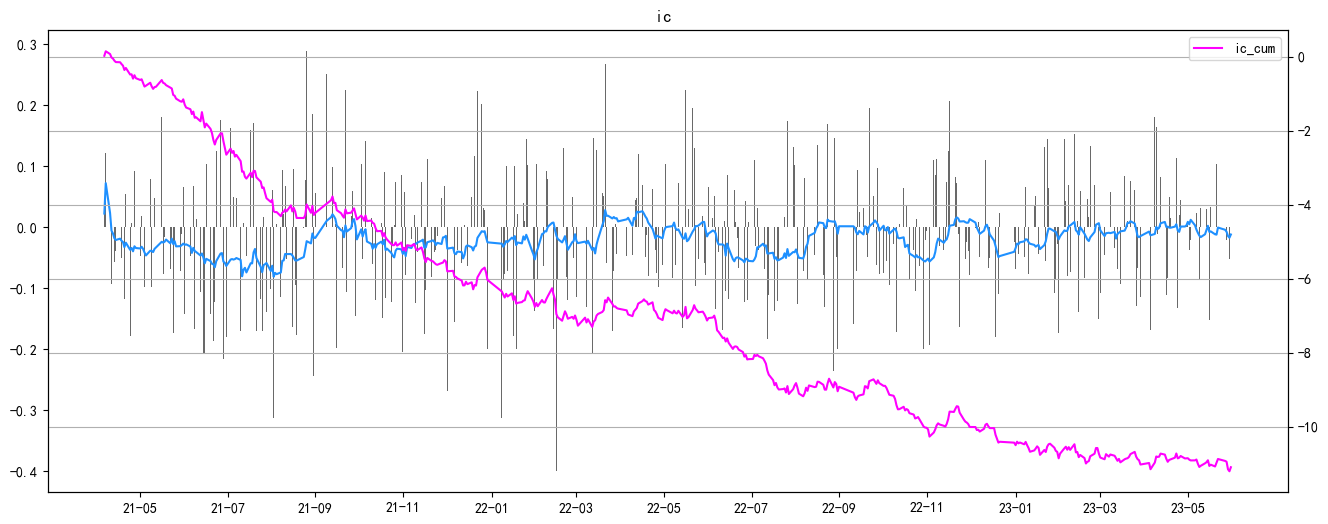

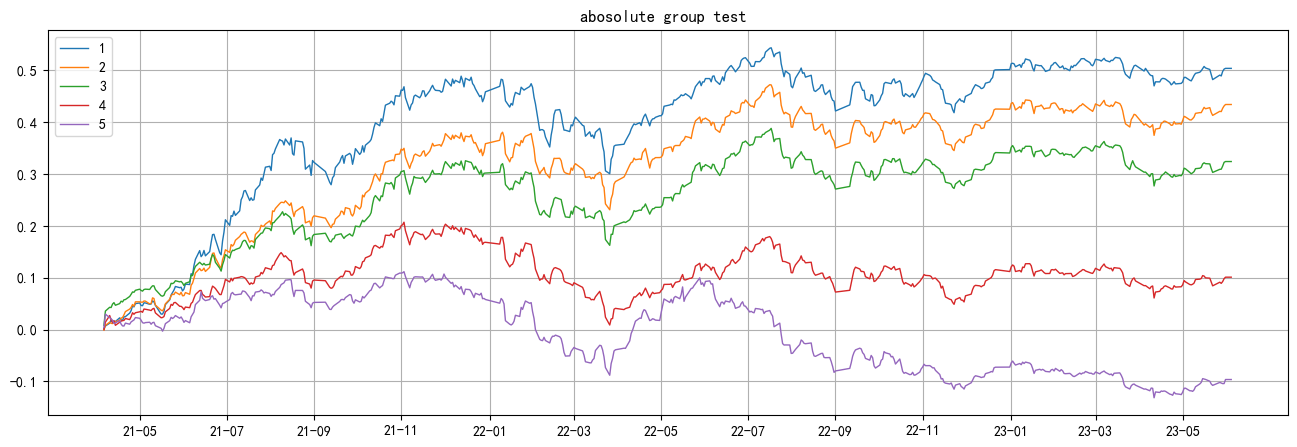

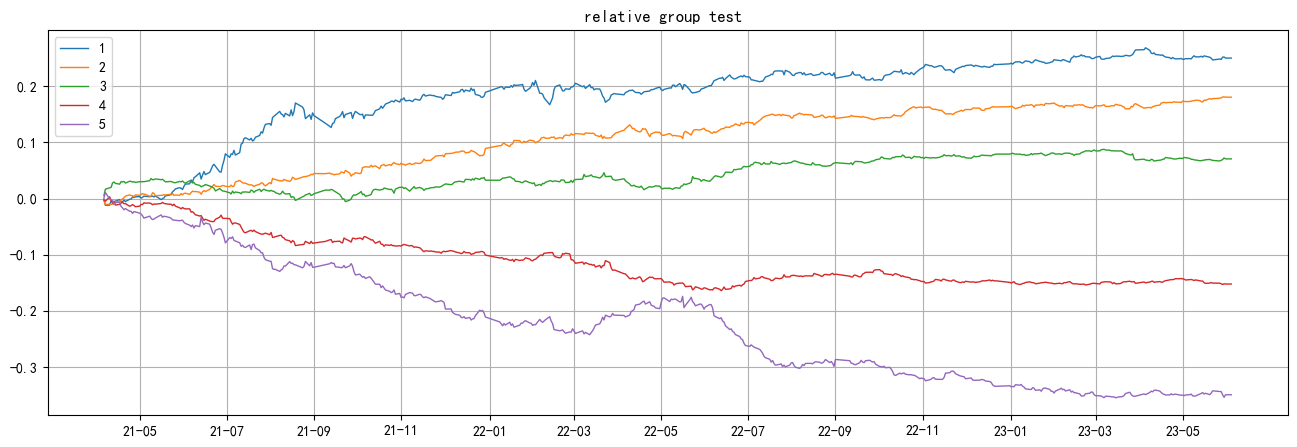

In [117]:
look(data0,factor,r,thresh=0.01, div_num=20)
analyse_ic(data0,factor,r)    
analyse_group_new(data0,factor,r,is_alpha=False,num_group=5)
analyse_group_new(data0,factor,r,is_alpha=True,num_group=5)

<Figure size 1500x1200 with 0 Axes>

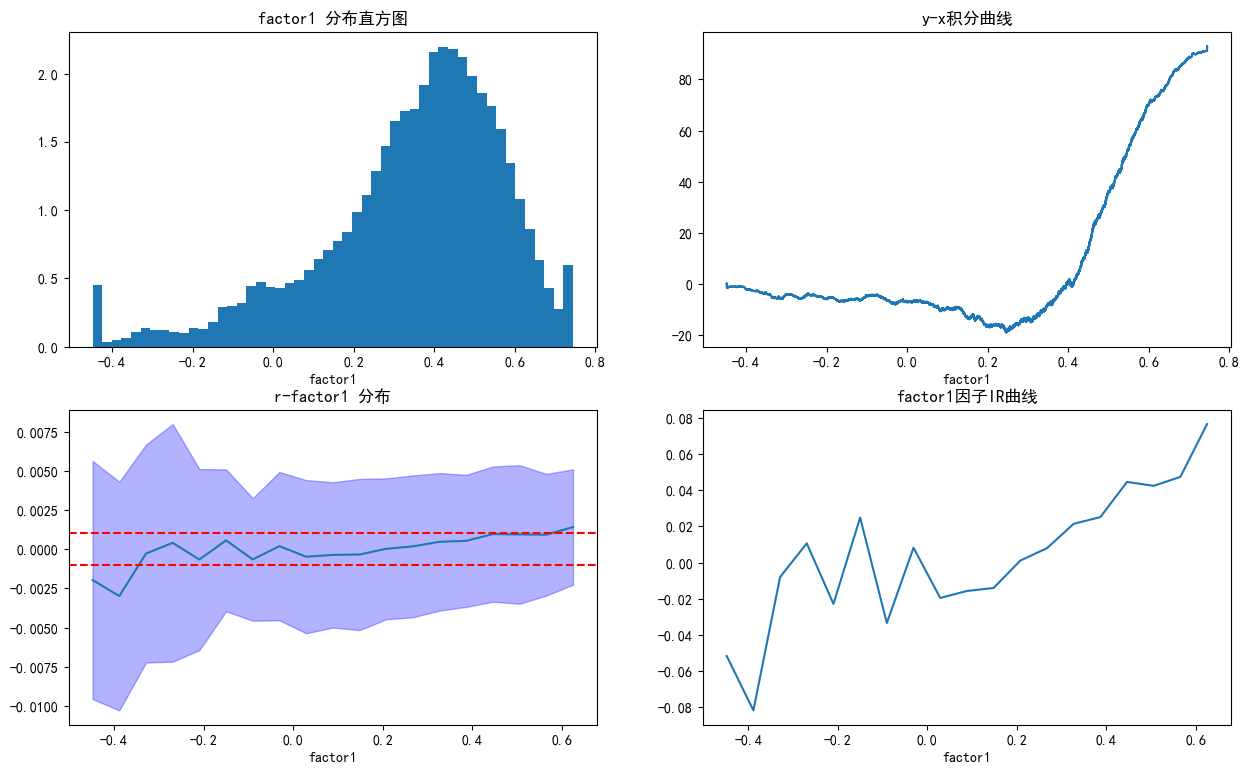

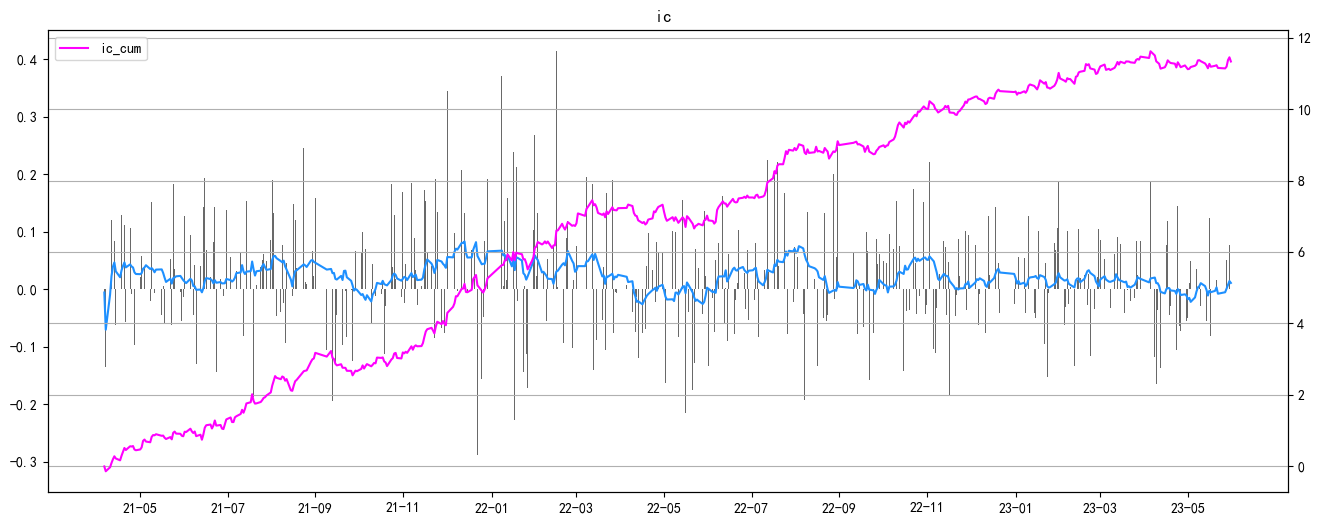

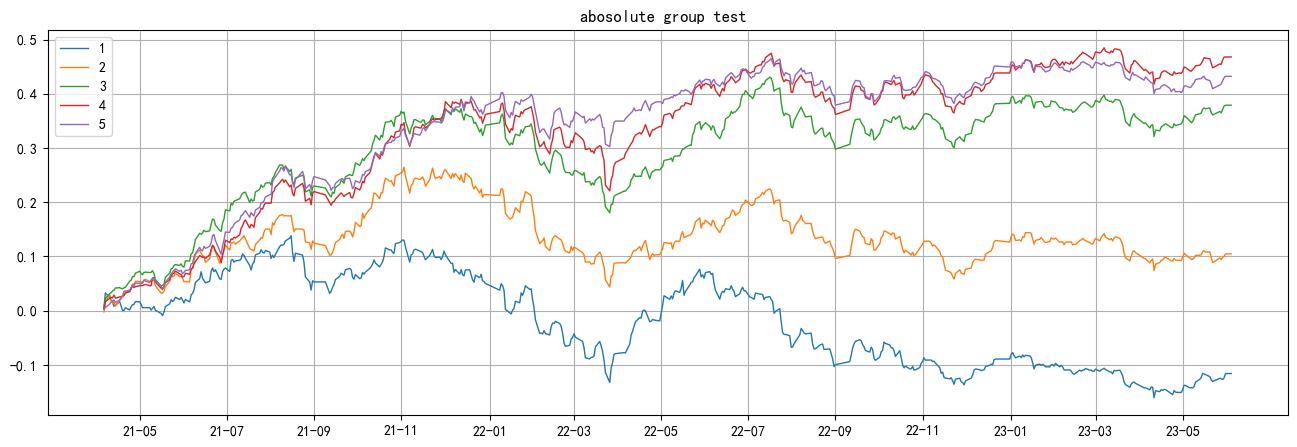

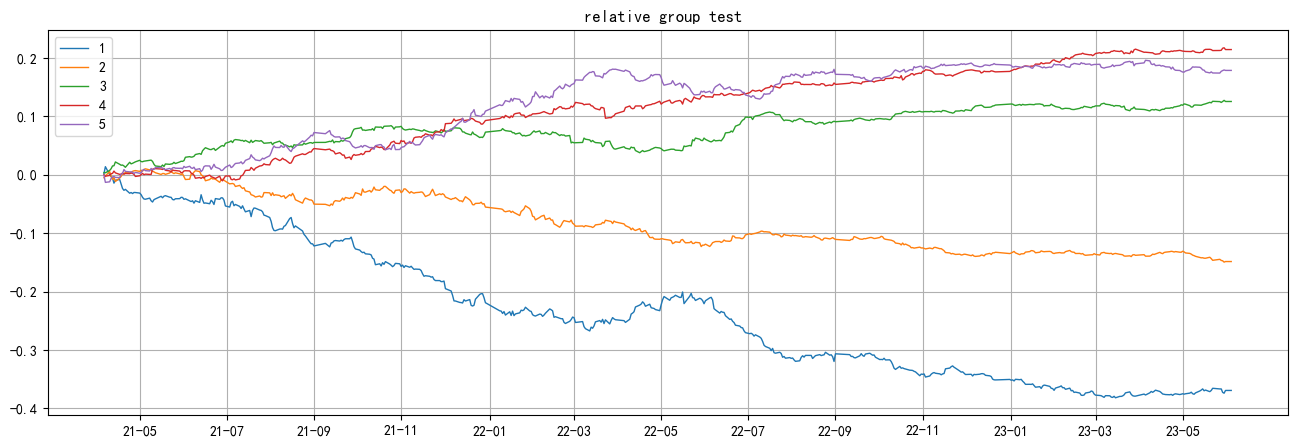

In [118]:
look(data0,factor1,r,thresh=0.01, div_num=20)
analyse_ic(data0,factor1,r)    
analyse_group_new(data0,factor1,r,is_alpha=False,num_group=5)
analyse_group_new(data0,factor1,r,is_alpha=True,num_group=5)

<Figure size 1500x1200 with 0 Axes>

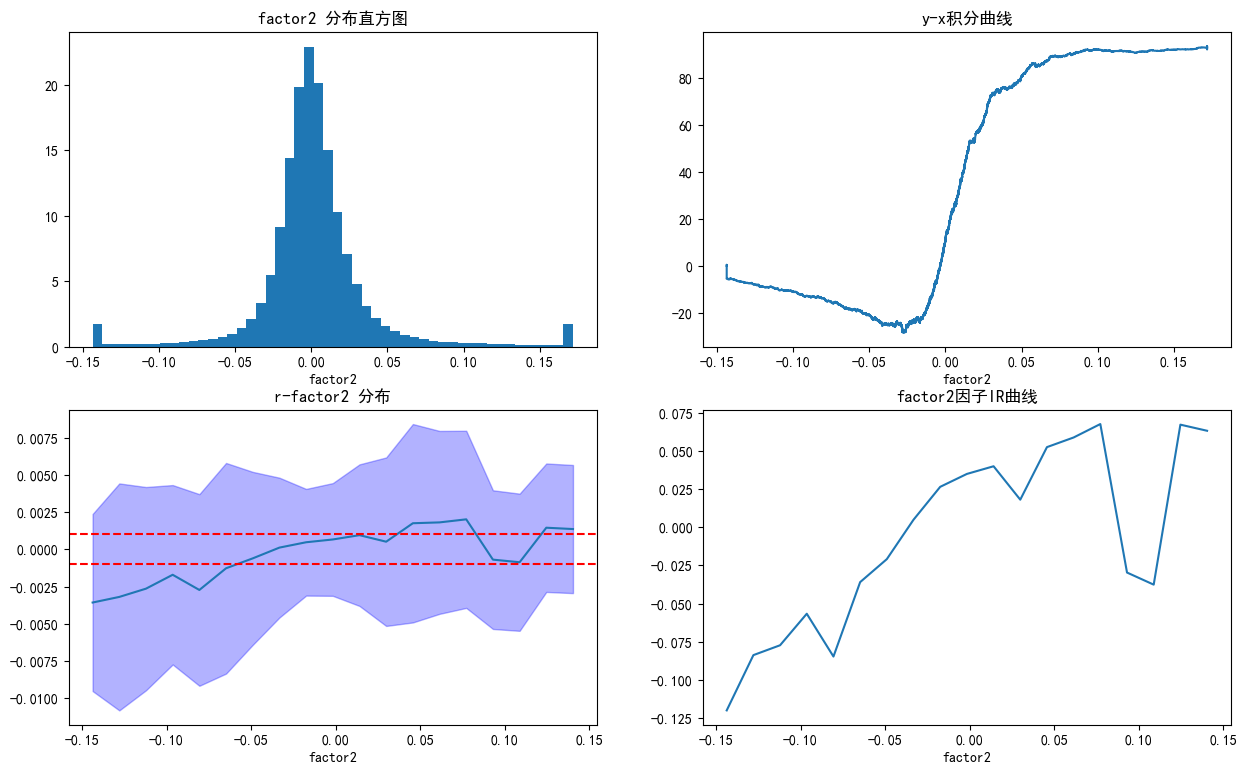

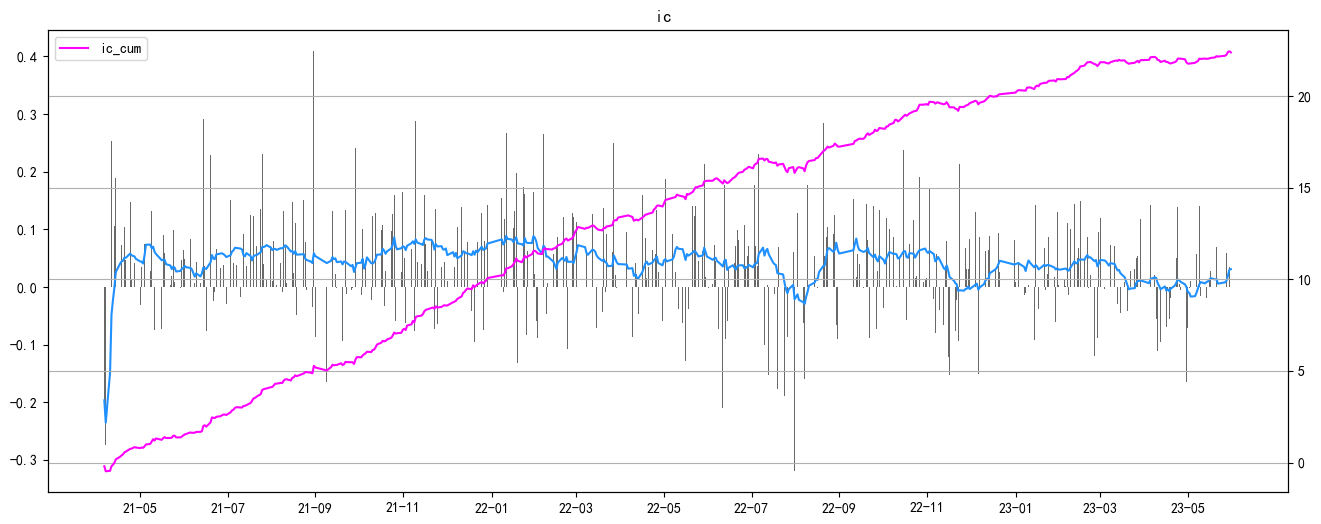

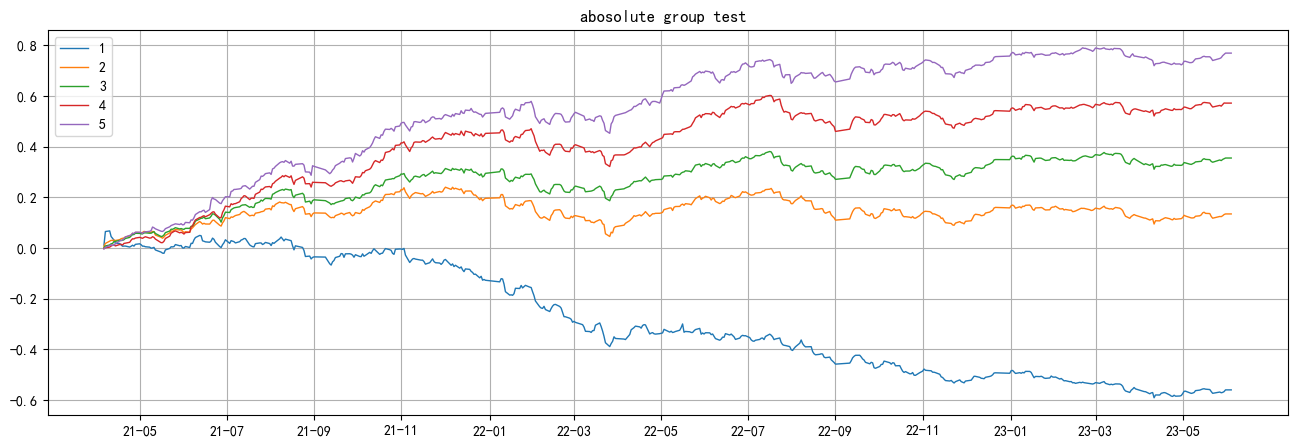

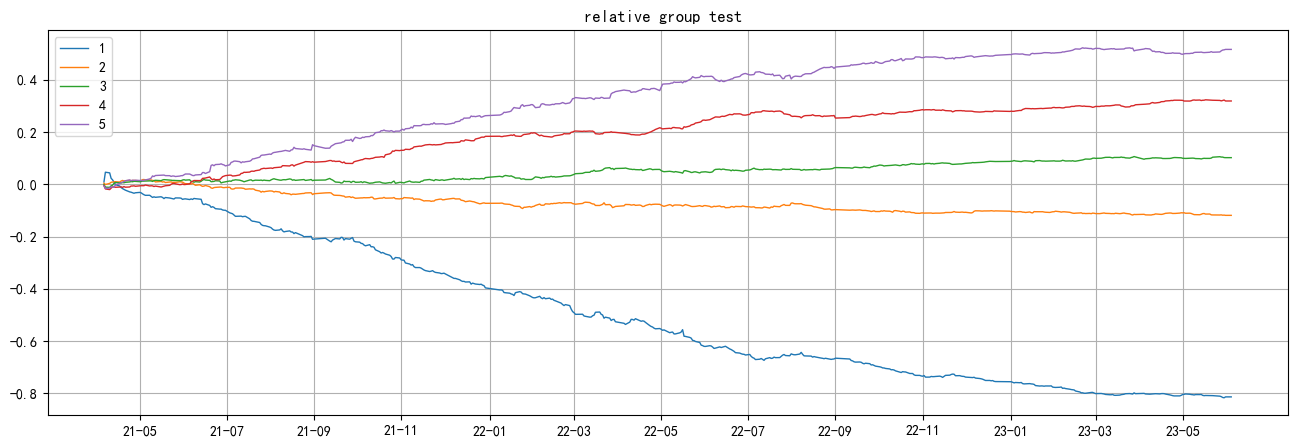

In [119]:
look(data0,factor2,r,thresh=0.01, div_num=20)
analyse_ic(data0,factor2,r)    
analyse_group_new(data0,factor2,r,is_alpha=False,num_group=5)
analyse_group_new(data0,factor2,r,is_alpha=True,num_group=5)